PREPROCESSING STEP


In [ ]:
import os
import imageio
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from facenet_pytorch import MTCNN

# === Set up device and face detector
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mtcnn = MTCNN(image_size=224, device=device, keep_all=False)

# === Paths to your real/fake .mp4 videos
REAL_PATH = "/content/drive/MyDrive/FF++/real"
FAKE_PATH = "/content/drive/MyDrive/FF++/fake"

# === Face extractor function (extracts N faces per video)
def extract_faces_from_videos(video_dir, label, max_faces_per_video=5, step=10):
    data = []  # Will hold (tensor, label) pairs
    all_faces = []  # For showing sample images

    for fname in tqdm(os.listdir(video_dir), desc=f"Extracting {'Real' if label==0 else 'Fake'}"):
        if not fname.endswith(".mp4"): continue
        path = os.path.join(video_dir, fname)
        try:
            reader = imageio.get_reader(path)
            count = 0
            for i, frame in enumerate(reader):
                if i % step != 0: continue  # skip frames
                img = Image.fromarray(frame)
                face = mtcnn(img)
                if face is not None:
                    data.append((face, label))
                    all_faces.append(face)
                    count += 1
                if count >= max_faces_per_video:
                    break
        except Exception as e:
            print(f"❌ Failed on {fname}: {e}")
    return data, all_faces


Extracting Fake: 100%|██████████| 172/172 [05:56<00:00,  2.07s/it]


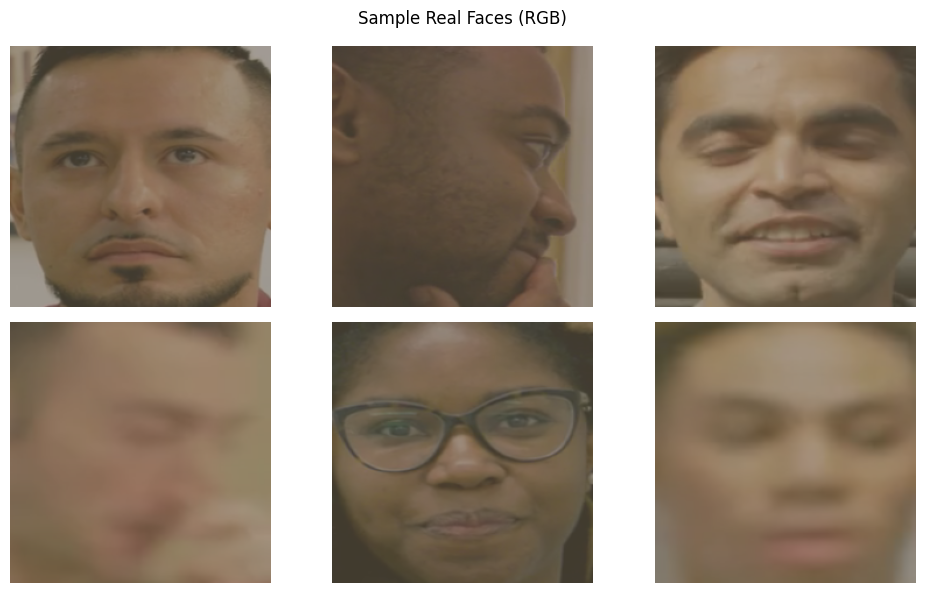

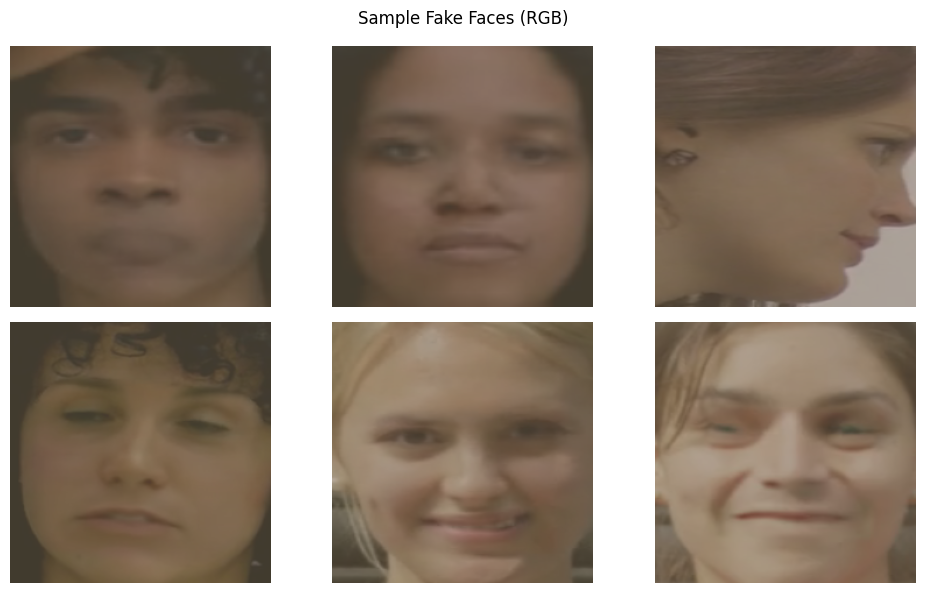

In [ ]:
# === Extract from real and fake
real_data, real_faces = extract_faces_from_videos(REAL_PATH, label=0)
fake_data, fake_faces = extract_faces_from_videos(FAKE_PATH, label=1)

# Combine training data
train_data = real_data + fake_data

# === Show 6 sample faces (random)
def show_faces(faces, title):
    plt.figure(figsize=(10, 6))
    for i, face in enumerate(random.sample(faces, min(6, len(faces)))):
        plt.subplot(2, 3, i+1)
        np_face = face.permute(1, 2, 0).cpu().numpy()  # CxHxW → HxWxC
        np_face = (np_face * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # unnormalize
        np_face = np.clip(np_face, 0, 1)
        plt.imshow(np_face)
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_faces(real_faces, "Sample Real Faces (RGB)")
show_faces(fake_faces, "Sample Fake Faces (RGB)")


APPLYING RGB STYLE ON THE FACES


In [ ]:
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms

def rgb_face_transform(face_tensor):
    """
    Apply RGB-style preprocessing like your uploaded sample.
    Input: face_tensor (C x H x W)
    Output: transformed face_tensor (C x H x W)
    """
    # Convert to numpy image
    face = face_tensor.permute(1, 2, 0).cpu().numpy() * 255
    face = face.astype(np.uint8)

    # Convert to BGR for OpenCV processing
    face_bgr = cv2.cvtColor(face, cv2.COLOR_RGB2BGR)

    # Apply CLAHE to each channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    channels = cv2.split(face_bgr)
    clahe_channels = [clahe.apply(c) for c in channels]
    face_eq = cv2.merge(clahe_channels)

    # Add heatmap effect to simulate deepfake artifacts
    heatmap = cv2.applyColorMap(face_eq, cv2.COLORMAP_JET)
    blended = cv2.addWeighted(face_eq, 0.6, heatmap, 0.4, 0)

    # Convert back to RGB
    face_rgb = cv2.cvtColor(blended, cv2.COLOR_BGR2RGB)

    # Convert to normalized tensor
    transform_pipeline = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    return transform_pipeline(face_rgb)


In [ ]:
from tqdm import tqdm
import imageio
from PIL import Image

def extract_transformed_faces(video_dir, label, max_faces_per_video=5, step=10):
    data = []  # list of (transformed_tensor, label)
    for fname in tqdm(os.listdir(video_dir), desc=f"Extracting {'Real' if label==0 else 'Fake'}"):
        if not fname.endswith(".mp4"): continue
        path = os.path.join(video_dir, fname)
        try:
            reader = imageio.get_reader(path)
            face_count = 0
            for i, frame in enumerate(reader):
                if i % step != 0: continue
                img = Image.fromarray(frame)
                face = mtcnn(img)
                if face is not None:
                    transformed = rgb_face_transform(face)
                    data.append((transformed, label))
                    face_count += 1
                if face_count >= max_faces_per_video:
                    break
        except Exception as e:
            print(f"❌ Error processing {fname}: {e}")
    return data


In [ ]:
REAL_PATH = "/content/drive/MyDrive/FF++/real"
FAKE_PATH = "/content/drive/MyDrive/FF++/fake"

real_data = extract_transformed_faces(REAL_PATH, label=0)
fake_data = extract_transformed_faces(FAKE_PATH, label=1)

train_data = real_data + fake_data
random.shuffle(train_data)


Extracting Fake: 100%|██████████| 172/172 [04:51<00:00,  1.69s/it]


SPLITTING OF DATASETS

In [ ]:
from torch.utils.data import Dataset, DataLoader

class FaceTrainDataset(Dataset):
    def __init__(self, data):
        self.data = data  # list of (tensor, label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        face_tensor, label = self.data[idx]
        return face_tensor, label

# Split into train and val sets
random.shuffle(train_data)
split_idx = int(0.8 * len(train_data))
train_split = train_data[:split_idx]
val_split = train_data[split_idx:]

# Loaders
train_dataset = FaceTrainDataset(train_split)
val_dataset = FaceTrainDataset(val_split)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
import torchvision.models as models
import torch.nn as nn

mobilenet = models.mobilenet_v2(pretrained=True)
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, 2)  # 2 classes: real/fake
mobilenet = mobilenet.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 54.0MB/s]


TRAINING PROCESS


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet.parameters(), lr=1e-4)


In [ ]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), torch.tensor(labels).to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


In [ ]:
def train(model, train_loader, val_loader, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), torch.tensor(labels).to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc = evaluate(model, val_loader)

        print(f"✅ Epoch {epoch+1}: Loss = {running_loss:.4f} | Train Acc = {train_acc:.4f} | Val Acc = {val_acc:.4f}")


In [ ]:
train(mobilenet, train_loader, val_loader, epochs=5)  # Increase epochs later if needed
torch.save(mobilenet.state_dict(), "mobilenet_rgb_faces.pth")



Epoch 1/5:   0%|          | 0/42 [00:00<?, ?it/s]/tmp/ipython-input-10-3470015543.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), torch.tensor(labels).to(device)
Epoch 1/5: 100%|██████████| 42/42 [00:05<00:00,  7.15it/s]
/tmp/ipython-input-9-1226329122.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), torch.tensor(labels).to(device)


✅ Epoch 1: Loss = 19.4597 | Train Acc = 0.7795 | Val Acc = 0.8776


Epoch 2/5: 100%|██████████| 42/42 [00:05<00:00,  8.28it/s]


✅ Epoch 2: Loss = 8.9757 | Train Acc = 0.9103 | Val Acc = 0.8955


Epoch 3/5: 100%|██████████| 42/42 [00:05<00:00,  8.32it/s]


✅ Epoch 3: Loss = 3.7630 | Train Acc = 0.9723 | Val Acc = 0.9224


Epoch 4/5: 100%|██████████| 42/42 [00:05<00:00,  8.18it/s]


✅ Epoch 4: Loss = 2.1127 | Train Acc = 0.9873 | Val Acc = 0.9104


Epoch 5/5: 100%|██████████| 42/42 [00:05<00:00,  8.23it/s]


✅ Epoch 5: Loss = 1.1698 | Train Acc = 0.9903 | Val Acc = 0.9104


TESTING AND EVALUATION

In [ ]:
import time
import pandas as pd
from torch.nn.functional import softmax

def classify_video(model, video_path, label, max_faces=20, step=10):
    reader = imageio.get_reader(video_path)
    predictions = []
    start_time = time.time()

    try:
        face_count = 0
        for i, frame in enumerate(reader):
            if i % step != 0: continue
            img = Image.fromarray(frame)
            face = mtcnn(img)
            if face is not None:
                transformed = rgb_face_transform(face).unsqueeze(0).to(device)
                with torch.no_grad():
                    output = model(transformed)
                    prob = softmax(output, dim=1)[0][1].item()  # Confidence for 'fake'
                    predictions.append(prob)
                    face_count += 1
                if face_count >= max_faces:
                    break

        if not predictions:
            return {"video": os.path.basename(video_path), "ground_truth": label,
                    "predicted": "unknown", "confidence_fake": 0.0, "inference_time_sec": -1}

        avg_conf = sum(predictions) / len(predictions)
        pred_label = 1 if avg_conf > 0.5 else 0
        elapsed = time.time() - start_time
        result_type = "Correct" if pred_label == label else "Wrong"

        return {"video": os.path.basename(video_path), "ground_truth": label,
                "predicted": pred_label, "confidence_fake": avg_conf,
                "inference_time_sec": round(elapsed, 2)}

    except Exception as e:
        return {"video": os.path.basename(video_path), "ground_truth": label,
                "predicted": "error", "confidence_fake": 0.0,
                "inference_time_sec": -1, "error": str(e)}


In [ ]:
from tqdm import tqdm

def evaluate_all_videos(model, real_dir, fake_dir):
    model.eval()
    real_results, fake_results = [], []

    for fname in tqdm(os.listdir(real_dir), desc="Testing Real"):
        if fname.endswith(".mp4"):
            result = classify_video(model, os.path.join(real_dir, fname), label=0)
            real_results.append(result)

    for fname in tqdm(os.listdir(fake_dir), desc="Testing Fake"):
        if fname.endswith(".mp4"):
            result = classify_video(model, os.path.join(fake_dir, fname), label=1)
            fake_results.append(result)

    return real_results, fake_results


In [ ]:
def save_and_score(real_results, fake_results):
    all_results = real_results + fake_results
    df = pd.DataFrame(all_results)
    df = df[df["predicted"] != "error"]

    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

    y_true = df["ground_truth"].astype(int)
    y_pred = df["predicted"].astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, df["confidence_fake"])

    print(f"\n🎯 Evaluation (Video-level)")
    print(f"✅ Accuracy  : {acc:.4f}")
    print(f"✅ Precision : {prec:.4f}")
    print(f"✅ Recall    : {rec:.4f}")
    print(f"✅ F1 Score  : {f1:.4f}")
    print(f"✅ AUC-ROC   : {auc:.4f}")

    pd.DataFrame(real_results).to_csv("mobilenet_real_mp4.csv", index=False)
    pd.DataFrame(fake_results).to_csv("mobilenet_fake_mp4.csv", index=False)


In [ ]:
REAL_PATH = "/content/drive/MyDrive/FF++/real"
FAKE_PATH = "/content/drive/MyDrive/FF++/fake"

real_results, fake_results = evaluate_all_videos(mobilenet, REAL_PATH, FAKE_PATH)
save_and_score(real_results, fake_results)


Testing Fake: 100%|██████████| 172/172 [15:21<00:00,  5.36s/it]



🎯 Evaluation (Video-level)
✅ Accuracy  : 0.9522
✅ Precision : 0.9643
✅ Recall    : 0.9419
✅ F1 Score  : 0.9529
✅ AUC-ROC   : 0.9867
